## Starbucks: Targeted Advertising Strategy

## Table of Contents
- [Introduction](#intro)
- [Part I - Import Data](#data)
- [Part II - Explore Data](#EDA)
- [Part III - Build Model 1](#mod1)
- [Part IV - Build Model 2](#mod2)
- [Part V - Build Model 3](#mod3)
- [Part VI - Build Model 4](#mod4)
- [Part VII - Build Model 5](#mod5)
- [Part VIII - Conclusion](#Conc)
- [Part IX - References](#ref)

<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 

<a id='intro'></a>
## Introduction
#### Background Information

The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

The task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$


#### How To Test Your Strategy?

The Starbucks team developed a strategy to achieve the following metrics on the test set:

* IRR of 0.0188
* NIR of 189.45

Once a model is developed, it can be tested using the complete the `promotion_strategy` function to pass to the `test_results` function. From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

<a id='data'></a>
## Part I - Import Data

In [35]:
# load in packages
from itertools import combinations

import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import plot_importance
import imblearn

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


<a id='EDA'></a>
## Part II - Explore Data

In [2]:
train_data.shape

(84534, 10)

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         84534 non-null  int64  
 1   Promotion  84534 non-null  object 
 2   purchase   84534 non-null  int64  
 3   V1         84534 non-null  int64  
 4   V2         84534 non-null  float64
 5   V3         84534 non-null  float64
 6   V4         84534 non-null  int64  
 7   V5         84534 non-null  int64  
 8   V6         84534 non-null  int64  
 9   V7         84534 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [4]:
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


In [57]:
#Validation Data
valid = pd.read_csv('Test.csv')

In [5]:
# Define training features
feats = train_data.columns[3:]

In [6]:
#Control Group
control = train_data[train_data['Promotion'] == 'No']

In [7]:
# Test Group
treatment = train_data[train_data['Promotion'] == 'Yes']

In [8]:
# Compare purchase conversion
print(f'The conversion rate of Control group: {control.purchase.mean()*100:.2f}%\nThe conversion rate of Treatment group: {treatment.purchase.mean()*100:.2f}%')

The conversion rate of Control group: 0.76%
The conversion rate of Treatment group: 1.70%


In [9]:
#Baseline Incremental Response Rate (IRR) 
IRR = treatment.purchase.mean() - control.purchase.mean()

In [10]:
print(f'Baseline IRR from Promotional Trial: {IRR:.4f}')

Baseline IRR from Promotional Trial: 0.0095


In [11]:
#Baseline Net Incremental Revenue (NIR)
NIR = (10 * (treatment['purchase'] == 1).sum() - 0.15 * treatment.shape[0]) - 10 * (control.purchase == 1).sum()

In [12]:
print(f'Baseline Net Incremental Revenue from Promotional Trial: {NIR:.2f}')

Baseline Net Incremental Revenue from Promotional Trial: -2334.60


### Review distribution of Customer Features

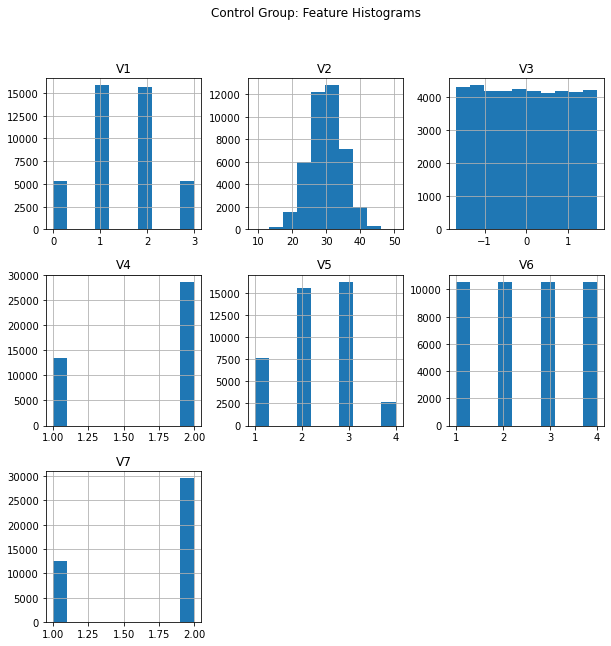

In [13]:
# Review control group distribution ovre seven key features
control.iloc[:,3:].hist(figsize = [10,10])
plt.suptitle('Control Group: Feature Histograms');

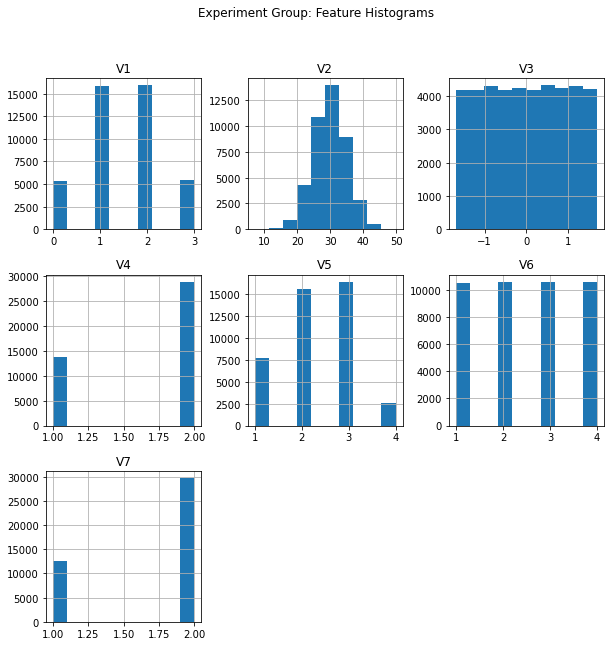

In [14]:
treatment.iloc[:,3:].hist(figsize = [10,10])
plt.suptitle('Experiment Group: Feature Histograms');

The above distributions show that the control and experiment groups appear relatively similar in their distribution across the seven variables. This shows that a fair split has been made on the allocation to each group.

Now lets look at the distributions of the Control and Experiment Group for those that purchased a product vs those that did not.

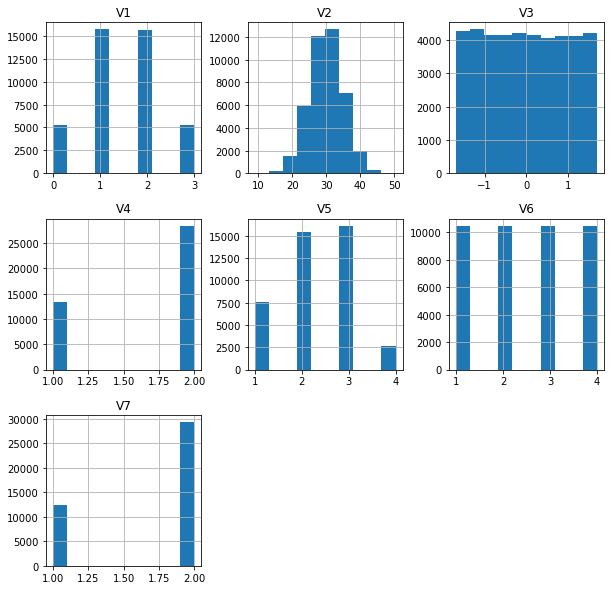

In [15]:
# Control that did not purchase 
control[control['purchase'] == 0].iloc[:,3:].hist(figsize=[10,10]);

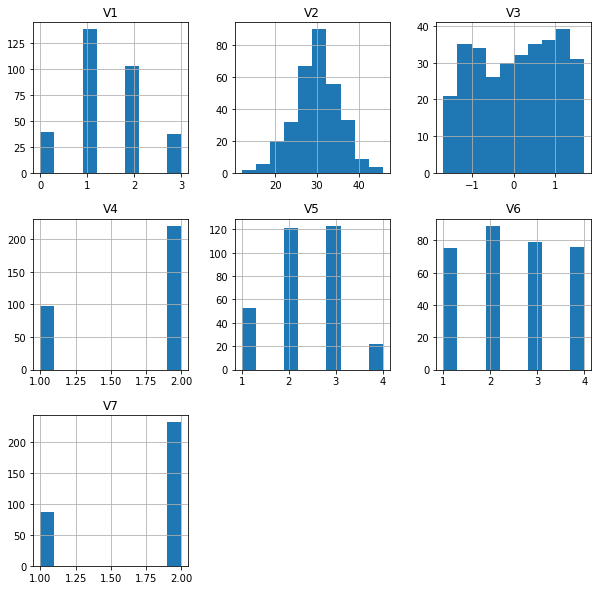

In [16]:
# Control that did purchase 
control[control['purchase'] == 1].iloc[:,3:].hist(figsize=[10,10]);

**Summary of Control Group Review**
Customers that purchased the item without receiving the offer had a higher proportion of customers with:
    
- a value of 1 for feature V1.
- a value of -1 or +1 for V3
- a value of 2 for V6

Aside from that there is little to differentiate the groups on features V2, V4, V5, V7

**Review of Treatment Group that Purchased vs Not-Purchased**

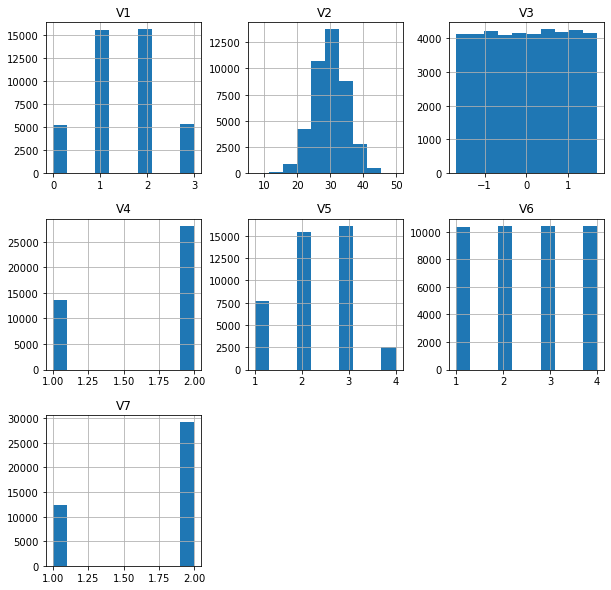

In [17]:
# Treatment that did not purchase 
treatment[treatment['purchase'] == 0].iloc[:,3:].hist(figsize=[10,10]);

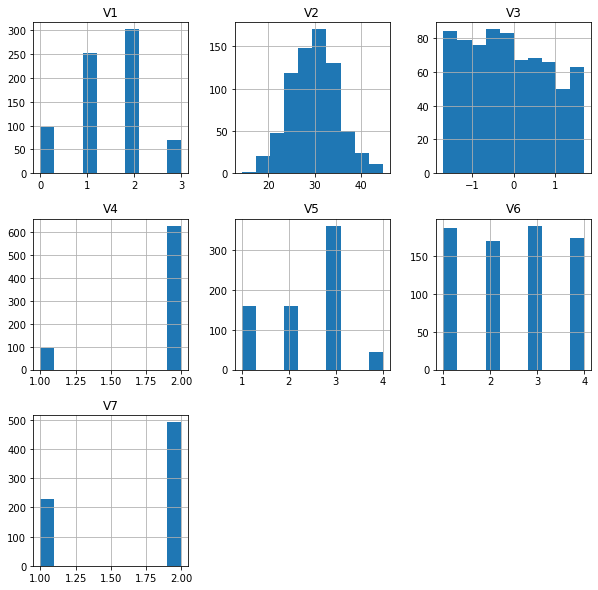

In [18]:
# Treatment that did purchase 
treatment[treatment['purchase'] == 1].iloc[:,3:].hist(figsize=[10,10]);

**Summary of Experiment Group Review**

Customers that purchased the item after receiving the offer had a higher proportion of customers with:
    
- a value of 3 for feature V1.
- a negative value of V3
- a value of 3 for V5

Aside from that there is little to differentiate the groups on features V2, V4, V6, V7

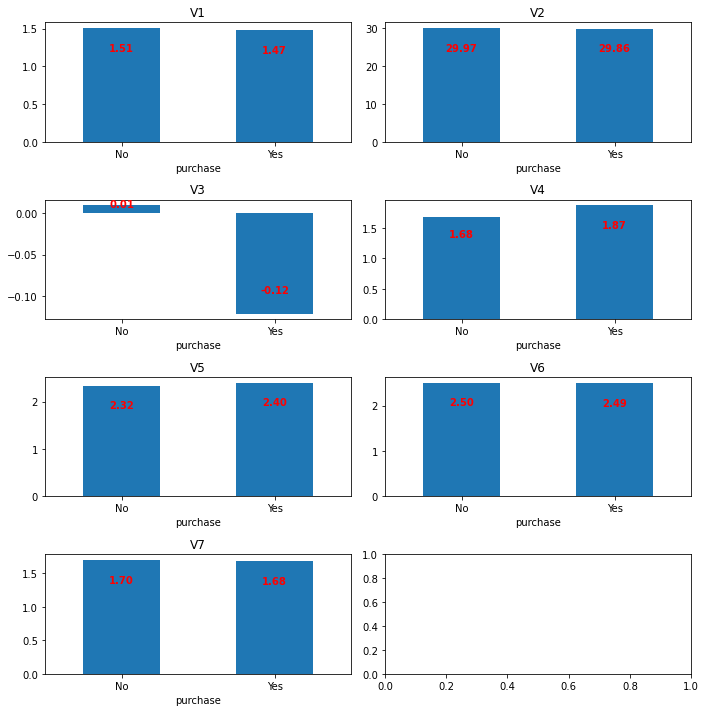

In [19]:
#Lets review the features of those in the Treatment Group which Purchased the promotion
fig, ax = plt.subplots(4,2,figsize=(10,10))
ax = ax.flatten()

for axis, feat in zip(ax, treatment.columns[3:]):
    plt.sca(axis)
    treatment.groupby('purchase')[feat].mean().plot.bar(ax=axis)
    axis.set_xticklabels(['No','Yes'],rotation = 0)
    locs, lables = plt.xticks()
    
    for loc in locs:
        val = treatment.groupby('purchase')[feat].mean()[loc]
        string = f'{val:.2f}'
        offset = val*0.2
        plt.text(loc,val-offset,string,ha='center',color='r',fontdict={'weight':'bold'})
    
    plt.title(feat)
    plt.tight_layout()

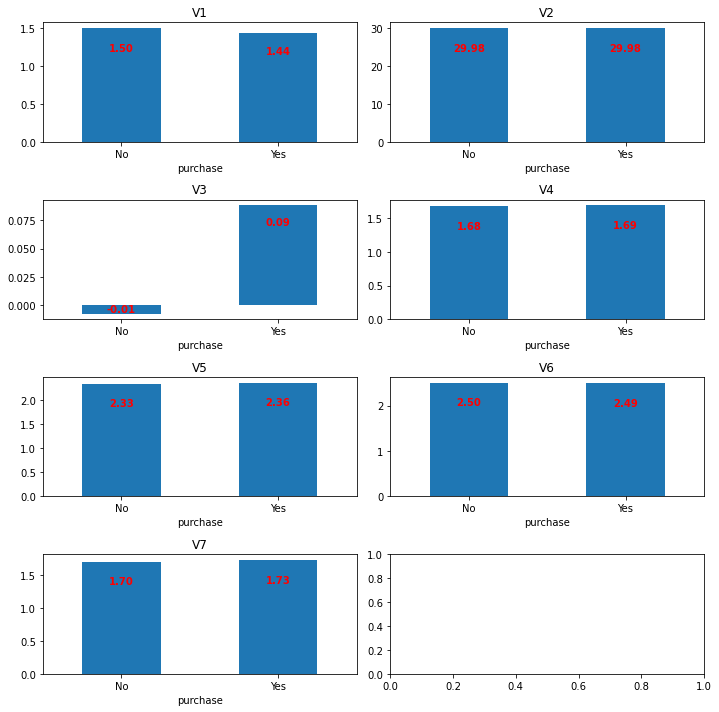

In [20]:
#Lets review the features of those in the Control Group which Purchased the promotion
fig, ax = plt.subplots(4,2,figsize=(10,10))

ax = ax.flatten()

for axis, feat in zip(ax, control.columns[3:]):
    plt.sca(axis)
    control.groupby('purchase')[feat].mean().plot.bar(ax=axis)
    axis.set_xticklabels(['No','Yes'],rotation = 0)
    locs, lables = plt.xticks()
    
    for loc in locs:
        val = control.groupby('purchase')[feat].mean()[loc]
        string = f'{val:.2f}'
        offset = val*0.2
        plt.text(loc,val-offset,string,ha='center',color='r',fontdict={'weight':'bold'})
    
    plt.title(feat)
    plt.tight_layout()

<a id='mod1'></a>
## Create a model to predict likelihood of customer using promotion

We only want to apply the promotion to customers who will use it. This has several benefits:

 * Optimises Advertising Budgets - Ensures money is not wasted presenting the offer to those that will not use it.
 * Improves User Experience (UX) - If a customer is likely to use it, they will feel as though they are getting good value which strengthens loyalty to the brand. It avoids "spamming" customers that wouldn't use the offer.

Lets make a category to identify the customers we would like to target. Specification:

 - They purchased the product

In [21]:
train_data['target'] = train_data.apply(lambda x: 1 if x['purchase'] == 1 else 0, axis=1)

ideal_cust = train_data[train_data['target'] == 1]['target'].sum()

print(f'We have identified {ideal_cust} customers from {train_data.shape[0]} from which we would like to develop a model.\n\
The model will aim to identify customers who are likely to purhcase the product based on features (V1-V7)\n\
Promotions will then only be sent to these customers.')

#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:,3:-1],train_data.target, test_size=0.2)

We have identified 1040 customers from 84534 from which we would like to develop a model.
The model will aim to identify customers who are likely to purhcase the product based on features (V1-V7)
Promotions will then only be sent to these customers.


In [22]:
#Check for content of target customers
y_train.sum()

842

In [23]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=2000, learning_rate=0.5)
clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.5, n_estimators=2000)

In [24]:
y_predict = clf.predict(X_test)

In [26]:
# This model does not perform well. It matches only two of the target values
[p for p, t in zip(y_predict, y_test) if p == 1 and t == 1]

[1, 1]

In [27]:
clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 3,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(max_depth=3),
 'learning_rate': 0.5,
 'n_estimators': 2000,
 'random_state': None}

In [28]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     16709
           1       0.02      0.01      0.01       198

    accuracy                           0.98     16907
   macro avg       0.51      0.50      0.50     16907
weighted avg       0.98      0.98      0.98     16907



In [29]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion = clf.predict(df)
    
    return np.array(['Yes' if p == 1 else 'No' for p in promotion])

In [38]:
#Calculate Business Metrics
def score(df, promo_pred_col = 'Promotion'):
    n_treat       = df.loc[df[promo_pred_col] == 'Yes',:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 'No',:].shape[0]
    n_treat_purch = df.loc[df[promo_pred_col] == 'Yes', 'purchase'].sum()
    n_ctrl_purch  = df.loc[df[promo_pred_col] == 'No', 'purchase'].sum()
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    return (irr, nir)
    
# Check model against test data
def test_results(promotion_strategy):
    test_data = pd.read_csv('Test.csv')
    df = test_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
    promos = promotion_strategy(df)
    score_df = test_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
    print("See how well your strategy worked on our test data below!\n")
    print('Your IRR: {:0.4f}.'.format(irr),'\n')
    print('Your NIR: {:0.2f}.'.format(nir),'\n')
    
    print("Starbucks model on the test set:\n\nIRR: {},\n\nNIR: {}\n".format(0.0188, 189.45))
    return irr, nir

In [39]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

See how well your strategy worked on our test data below!

Your IRR: 0.0185. 

Your NIR: 3.95. 

Starbucks model on the test set:

IRR: 0.0188,

NIR: 189.45



(0.01851357365376057, 3.9499999999999993)

As can be seen, this model did not perform well. This is likely due to the target data being in such a low proportion to the rest of the model.

<i>"Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance.

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short."</i> [References](#ref) 

<a id='mod2'></a>
## Model Two: Applying SMOTE 

In [40]:
# Transform the data with Synthetic Minority Oversampling Technique (SMOTE)
oversample = imblearn.over_sampling.SMOTE()

In [41]:
X_smote, y_smote = oversample.fit_resample(X_train,y_train)

In [42]:
# Retrain model with over smapled minority data
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=2000, learning_rate=0.5)
clf.fit(X_smote, y_smote)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.5, n_estimators=2000)

In [43]:
y_predict = clf.predict(X_test)

In [44]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     16709
           1       0.01      0.02      0.02       198

    accuracy                           0.97     16907
   macro avg       0.50      0.50      0.50     16907
weighted avg       0.98      0.97      0.97     16907



In [45]:
# This model does not perform well. It matches non of the target values
[p for p, t in zip(y_predict, y_test) if p == 1 and t == 1]

[1, 1, 1, 1]

This shows only a marginal improvement because we are at least able to identify the minority group in the test data now. But the recall & precision of the minority group is far too low to be effective for increasing our business metrics IRR and NIR. 

In [50]:
def promotion_strategy(df):
    promotion = clf.predict(df)
    
    return np.array(['Yes' if p == 1 else 'No' for p in promotion])

In [51]:
test_results(promotion_strategy)

See how well your strategy worked on our test data below!

Your IRR: 0.0101. 

Your NIR: -15.20. 

Starbucks model on the test set:

IRR: 0.0188,

NIR: 189.45



(0.010079895949461164, -15.199999999999996)

<a id='mod3'></a>
## Model Three: Applying SMOTE
### Oversample Minority combined with XGB Classifier

In [52]:
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.9)

X_over, y_over = over.fit_resample(X_train, y_train)

model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)

eval_set = [(X_over,y_over),(X_test,y_test)]

model.fit(X_over, y_over,eval_set=eval_set,eval_metric='auc',\
          verbose=True,early_stopping_rounds=30)

[0]	validation_0-auc:0.70415	validation_1-auc:0.54515
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.72740	validation_1-auc:0.52921
[2]	validation_0-auc:0.75149	validation_1-auc:0.53028
[3]	validation_0-auc:0.77250	validation_1-auc:0.53735
[4]	validation_0-auc:0.77472	validation_1-auc:0.53749
[5]	validation_0-auc:0.79953	validation_1-auc:0.53334
[6]	validation_0-auc:0.79583	validation_1-auc:0.53417
[7]	validation_0-auc:0.80262	validation_1-auc:0.53491
[8]	validation_0-auc:0.81321	validation_1-auc:0.53195
[9]	validation_0-auc:0.81967	validation_1-auc:0.53031
[10]	validation_0-auc:0.83750	validation_1-auc:0.53295
[11]	validation_0-auc:0.85008	validation_1-auc:0.53291
[12]	validation_0-auc:0.85197	validation_1-auc:0.53107
[13]	validation_0-auc:0.85745	validation_1-auc:0.52929
[14]	validation_0-auc:0.85975	validation_1-auc:0.53010
[15]	validation_0-auc:0.8747

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

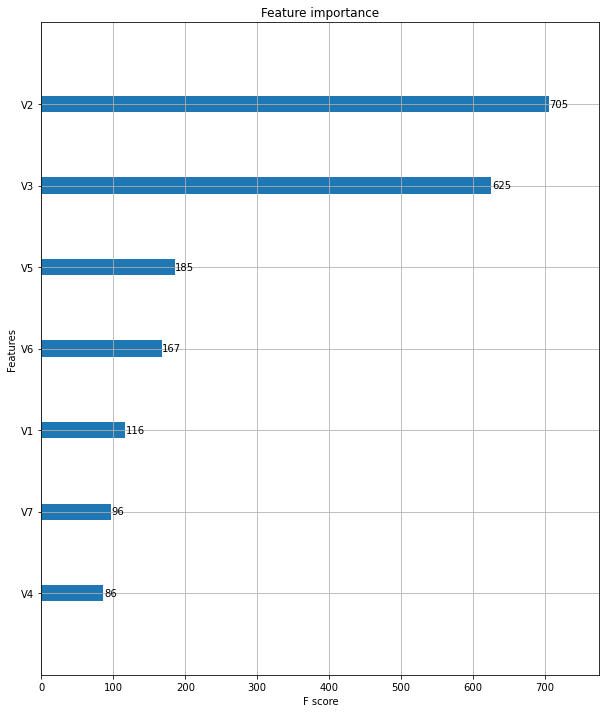

In [53]:
#Check which features are most important
fig, ax = plt.subplots(figsize=[10,12])
xgb.plot_importance(model, ax=ax)

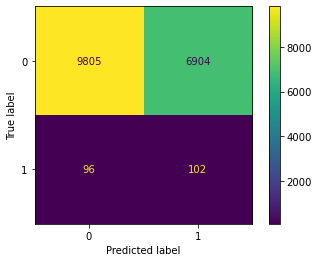

In [54]:
plot_confusion_matrix(model,X_test,y_test)

In [55]:
def promotion_strategy(df):

    promotion = model.predict(df)
    
    return np.array(['Yes' if p == 1 else 'No' for p in promotion])

In [56]:
test_results(promotion_strategy)

See how well your strategy worked on our test data below!

Your IRR: 0.0158. 

Your NIR: 52.40. 

Starbucks model on the test set:

IRR: 0.0188,

NIR: 189.45



(0.015807196471787542, 52.40000000000009)

Ok we can clearly see that our XGBoost Model performs quite well when an SMOTE technique is applied. We now need to optimise the SMOTE ratio.

<a id='mod4'></a>
## Model Four: Optimised SMOTE & XGB

In [60]:
s_strat = np.arange(0.1,1,0.01)

In [62]:
results = {'SMOTE':s_strat,'IRR': [],'NIR': []}

#Instantiate Model
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)

for ss in s_strat:
    #SMOTE
    over = imblearn.over_sampling.SMOTE(sampling_strategy=ss)
    X_over, y_over = over.fit_resample(X_train, y_train)
    
    #Fit Model
    model.fit(X_over, y_over,eval_set=eval_set,eval_metric='auc',verbose=False,early_stopping_rounds=30)
    
    #Evaluate Prediction
    
    promos = model.predict(valid[feats],ntree_limit = model.best_ntree_limit)
    promos = np.array(['Yes' if p == 1 else 'No' for p in promos])
    
    score_df = valid.iloc[np.where(promos == 'Yes')]    
    
    irr, nir = score(score_df)
    
    results['IRR'].append(irr)
    results['NIR'].append(nir)


In [64]:
df = pd.DataFrame.from_dict(results)

fig, ax = plt.subplots(figsize=[14,10])

ax.plot(df.SMOTE, df.IRR, label='IRR')
ax.set_ylabel('IRR',fontsize=15)
ax.legend(loc=2)
ax.set_xlabel('SMOTE Ratio',fontsize=15)

ax2 = ax.twinx()
ax2.plot(df.SMOTE, df.NIR, label='NIR', color='red')
ax2.set_ylabel('NIR',fontsize=15)
ax2.legend(loc=1);

It is evident that as my SMOTE ratio increases the recall of the minority group improves. However, at the same time the recall of the majority groups falls. 

Increased Target recall improves IRR, but wrongly indentifying customers for promotion costs us with NIR.

The plot of SMOTE ratio vs the two business metrics shows there is still a lot of variability in the data.

In [97]:
idx = results['NIR'].index(max(results['NIR']))

sm_max = results['SMOTE'][idx]

print(f'Highest NIR Obtained from SMOTE {sm_max:.2f}')

Check SMOTE ratio 0.59 a few times to check for best score

In [114]:
nir_results = []
irr_results = []

smote = 0.6

for i in range(10):
    #SMOTE
    over = imblearn.over_sampling.SMOTE(sampling_strategy=smote)
    X_over, y_over = over.fit_resample(X_train, y_train)

    #Creat Evaluation Param
    eval_set = [(X_over,y_over),(X_test,y_test)]

    #Fit Model
    model.fit(X_over, y_over,eval_set=eval_set,eval_metric='auc',verbose=False,early_stopping_rounds=30)

    #Evaluate Prediction

    promos = model.predict(valid[feats],ntree_limit = model.best_ntree_limit)
    promos = np.array(['Yes' if p == 1 else 'No' for p in promos])

    score_df = valid.iloc[np.where(promos == 'Yes')]    

    irr, nir = score(score_df)
    
    nir_results.append(nir)
    irr_results.append(irr)

In [115]:
max(nir_results)

129.90000000000003

<a id='mod5'></a>
## Model Five: SMOTE, XGB, Improved Target

Lets make a category to identify the customers we would like to target. Specification:

 - They received the **Promotion** and **Purchased the Product**

In [116]:
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [117]:
train_data['target'] = train_data.apply(lambda x: 1 if x['purchase'] == 1 and x['Promotion'] == 'Yes' else 0, axis=1)

In [118]:
ideal_cust = train_data[train_data['target'] == 1]['target'].sum()

print(f'We have identified {ideal_cust} customers from {train_data.shape[0]} from which we would like to develop a model.\n\
The model will aim to identify customers who are likely to purhcase the product based on features (V1-V7)\n\
Promotions will then only be sent to these customers.')

We have identified 721 customers from 84534 from which we would like to develop a model.
The model will aim to identify customers who are likely to purhcase the product based on features (V1-V7)
Promotions will then only be sent to these customers.


In [119]:
#Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:,3:-1],train_data.target, test_size=0.2)

In [120]:
# We have some targets in our training data which is essential
y_train.sum()

563

Lets check the performance of the business metric over a range of SMOTE ratios from 0.5 - 1

In [121]:
s_strat = np.arange(0.39,0.81,0.01)

In [122]:
results = {'SMOTE':s_strat,'IRR': [],'NIR': []}

#Instantiate Model
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)

for ss in s_strat:
    #SMOTE
    over = imblearn.over_sampling.SMOTE(sampling_strategy=ss)
    X_over, y_over = over.fit_resample(X_train, y_train)
    
    #Fit Model
    model.fit(X_over, y_over,eval_set=eval_set,eval_metric='auc',verbose=False,early_stopping_rounds=30)
    
    #Evaluate Prediction
    
    promos = model.predict(valid[feats],ntree_limit = model.best_ntree_limit)
    promos = np.array(['Yes' if p == 1 else 'No' for p in promos])
    
    score_df = valid.iloc[np.where(promos == 'Yes')]    
    
    irr, nir = score(score_df)
    
    results['IRR'].append(irr)
    results['NIR'].append(nir)

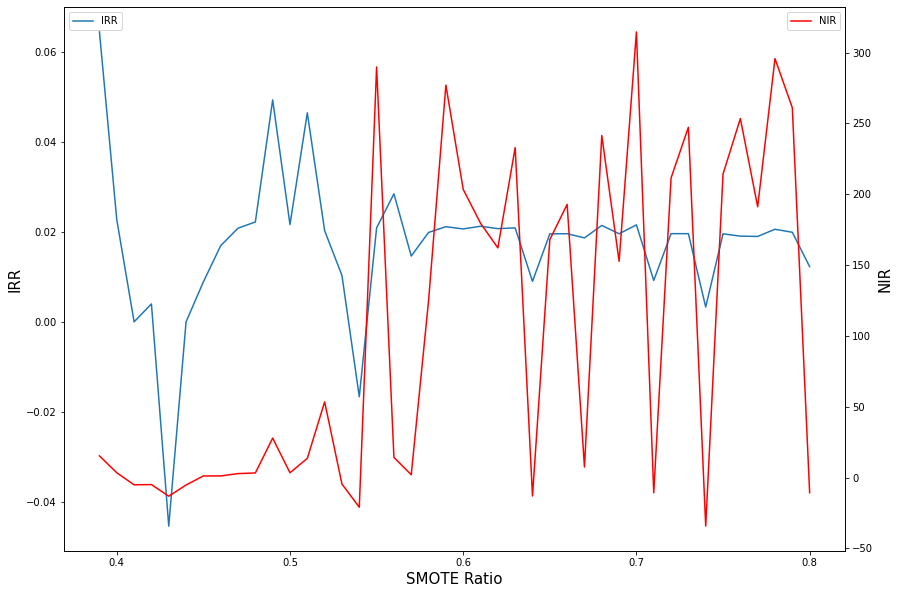

In [124]:
df = pd.DataFrame.from_dict(results)

fig, ax = plt.subplots(figsize=[14,10])

ax.plot(df.SMOTE, df.IRR, label='IRR')
ax.set_ylabel('IRR',fontsize=15)
ax.legend(loc=2)
ax.set_xlabel('SMOTE Ratio',fontsize=15)

ax2 = ax.twinx()
ax2.plot(df.SMOTE, df.NIR, label='NIR', color='red')
ax2.set_ylabel('NIR',fontsize=15)
ax2.legend(loc=1);

Refine the optimisation between 0.6 and 0.8 SMOTE ratio. I'll also fun each model several times and take the best result to account for the randomness with the model training.

In [135]:
s_strat = np.arange(0.59,0.81,0.01)
results = {'SMOTE':s_strat,'IRR': [],'NIR': []}

#Instantiate Model
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)

for ss in s_strat:
    print(f'Testing SMOTE {ss}\n\n')
    temp_nir = 0
    temp_irr = None
    for _ in range(5):
        #SMOTE
        over = imblearn.over_sampling.SMOTE(sampling_strategy=ss)
        X_over, y_over = over.fit_resample(X_train, y_train)

        #Fit Model
        model.fit(X_over, y_over,eval_set=eval_set,eval_metric='auc',verbose=False,early_stopping_rounds=30)

        #Evaluate Prediction

        promos = model.predict(valid[feats],ntree_limit = model.best_ntree_limit)
        promos = np.array(['Yes' if p == 1 else 'No' for p in promos])

        score_df = valid.iloc[np.where(promos == 'Yes')]    

        irr, nir = score(score_df)
        
        if nir > temp_nir:
            temp_nir = nir
            temp_irr = irr
        
    #Append best result
    results['IRR'].append(temp_irr)
    results['NIR'].append(temp_nir)

Testing SMOTE 0.59


Testing SMOTE 0.6


Testing SMOTE 0.61


Testing SMOTE 0.62


Testing SMOTE 0.63


Testing SMOTE 0.64


Testing SMOTE 0.65


Testing SMOTE 0.66


Testing SMOTE 0.67


Testing SMOTE 0.68


Testing SMOTE 0.6900000000000001


Testing SMOTE 0.7000000000000001


Testing SMOTE 0.7100000000000001


Testing SMOTE 0.7200000000000001


Testing SMOTE 0.7300000000000001


Testing SMOTE 0.7400000000000001


Testing SMOTE 0.7500000000000001


Testing SMOTE 0.7600000000000001


Testing SMOTE 0.7700000000000001


Testing SMOTE 0.7800000000000001


Testing SMOTE 0.7900000000000001


Testing SMOTE 0.8000000000000002


Testing SMOTE 0.8100000000000002




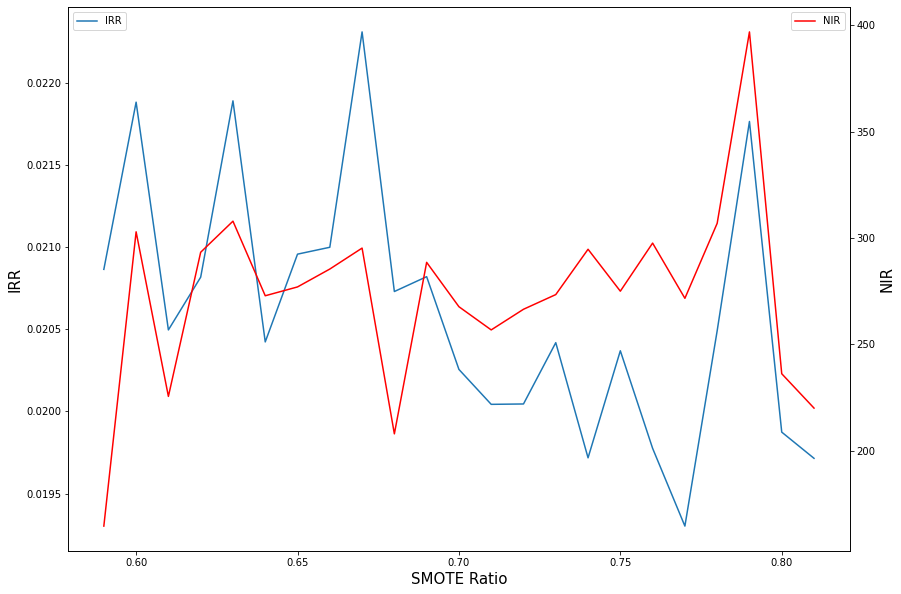

In [136]:
df = pd.DataFrame.from_dict(results)

fig, ax = plt.subplots(figsize=[14,10])

ax.plot(df.SMOTE, df.IRR, label='IRR')
ax.set_ylabel('IRR',fontsize=15)
ax.legend(loc=2)
ax.set_xlabel('SMOTE Ratio',fontsize=15)

ax2 = ax.twinx()
ax2.plot(df.SMOTE, df.NIR, label='NIR', color='red')
ax2.set_ylabel('NIR',fontsize=15)
ax2.legend(loc=1);

<a id='Conc'></a>
## Conclusion

The final model is able predict which customers are most likely to utilise the promotion offer to a higher degree of accuracy than the original Starbucks model. This has enabled a higher business metric of Net Incremental Revenue (NIR) to be achieved. 

This is not only a success for the business in terms of revenue, but it also leads to higher overall customer satisfaction. You do not "Spam" customers who wouldn't utilise the offer and those that do use it get value for money.

In [410]:
idx = results['NIR'].index(max(results['NIR']))
sm_max = results['SMOTE'][idx]

In [138]:
print(f'As the above charts show, the model reaches an optimum at a SMOTE ratio of {sm_max:.2f}')

As the above charts show, the model reaches an optimum at a SMOTE ratio of 0.79


In [152]:
#SMOTE
over = imblearn.over_sampling.SMOTE(sampling_strategy=sm_max)
X_over, y_over = over.fit_resample(X_train, y_train)
#Instantiate Model
model = xgb.XGBClassifier(learning_rate = 0.1,\
                      max_depth = 7,\
                      min_child_weight = 5,\
                      objective = 'binary:logistic',\
                      seed = 42,\
                      gamma = 0.1,\
                      silent = True)
#Creat Evaluation Param
eval_set = [(X_over,y_over),(X_test,y_test)]
#Fit Model
model.fit(X_over, y_over,eval_set=eval_set,eval_metric='auc',verbose=False,early_stopping_rounds=30)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [153]:
#Define evaluation for business metrics
def promotion_strategy(df):
    promotion = model.predict(df)
    return np.array(['Yes' if p == 1 else 'No' for p in promotion])

test_results(promotion_strategy)

See how well your strategy worked on our test data below!

Your IRR: 0.0196. 

Your NIR: 282.80. 

Starbucks model on the test set:

IRR: 0.0188,

NIR: 189.45



(0.019566257130626243, 282.80000000000007)

<a id='ref'></a>
## References
1. [Starbucks Problem Description](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM) 
2. [SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)